In [61]:
import pandas as pd
from get_milestones import main
from path import Path
import os
from collections import Counter
import time
from tqdm.auto import tqdm
from Levenshtein import distance as lev
import numpy as np
from matplotlib import pyplot as plt
import difflib
from bs4 import BeautifulSoup
from multiprocessing import Pool
import re

In [22]:
df = pd.read_csv('./data/all_petitions_comments_20211112-095033.csv')

In [23]:
comments = list(df.comment)

In [101]:
def preprocess_comment(c):
    # removing HTML tags
    c = BeautifulSoup(c, "lxml").text
    
    # replacing newlines with a space
    c = c.replace("\n", " ")
    
    # removing non-alphanumeric characters
    c = re.sub(r'[^A-Za-z0-9. ]+', ' ', c)
    
    # replacing multiple spaces with a single one
    c = ' '.join(c.split())
    
    # to lowercase
    c = c.lower()
    
    return c

In [102]:
def map_parallel(array, fcn):
    with Pool(4) as p:
        array_out = list(tqdm(p.imap(fcn, array), total=len(array)))
        
    return array_out

In [ ]:
comments_processed = map_parallel(comments, preprocess_comment)

(array([2.7198e+04, 5.0000e+00, 1.0000e+00, 4.0000e+00, 0.0000e+00,
        6.0000e+00, 8.0000e+00, 1.0000e+00, 6.0000e+00, 9.0000e+00]),
 array([    0. ,  6440.2, 12880.4, 19320.6, 25760.8, 32201. , 38641.2,
        45081.4, 51521.6, 57961.8, 64402. ]),
 <BarContainer object of 10 artists>)

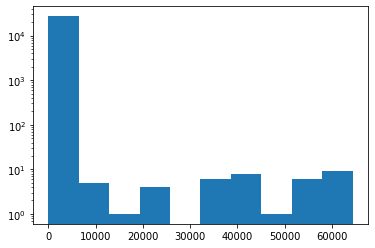

In [105]:
plt.hist(list(map(len, comments_processed)), log=True)

In [106]:
def mentioning(c):
    return 'amber heard' in c

In [107]:
comments_mentioning = [c for c in tqdm(comments_processed) if mentioning(c)]
orig_index_mentioning = [i for i, c in enumerate(comments_processed) if mentioning(c)]

  0%|          | 0/27238 [00:00<?, ?it/s]

(array([3.136e+03, 4.800e+01, 9.000e+00, 2.000e+00, 1.000e+00, 4.000e+00,
        3.000e+00, 0.000e+00, 1.000e+00, 3.000e+00]),
 array([  13. ,  932.1, 1851.2, 2770.3, 3689.4, 4608.5, 5527.6, 6446.7,
        7365.8, 8284.9, 9204. ]),
 <BarContainer object of 10 artists>)

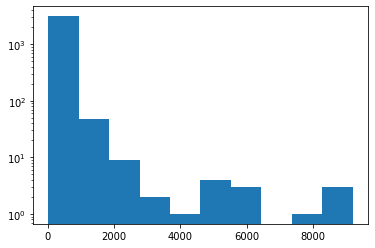

In [108]:
plt.hist(list(map(len, comments_mentioning)), log=True)

In [109]:
len(comments_mentioning)

3207

In [110]:
Counter(' '.join(comments_processed).split()).most_common(30)

[('the', 26880),
 ('and', 24989),
 ('a', 18179),
 ('to', 18098),
 ('is', 15215),
 ('of', 15197),
 ('i', 11246),
 ('in', 10626),
 ('she', 9834),
 ('johnny', 8315),
 ('that', 7957),
 ('for', 7755),
 ('he', 7546),
 ('s', 7078),
 ('be', 6419),
 ('her', 6353),
 ('not', 6217),
 ('this', 6167),
 ('depp', 6028),
 ('amber', 5803),
 ('it', 5768),
 ('was', 5029),
 ('with', 4620),
 ('as', 4211),
 ('heard', 4105),
 ('an', 4061),
 ('t', 4007),
 ('his', 3843),
 ('because', 3685),
 ('no', 3473)]

In [111]:
for comment, count in tqdm(Counter(comments_mentioning).most_common()):
    ids_found = [orig_index_mentioning[i] for i, c in enumerate(comments_mentioning) if c == comment]
    
    rows = df.iloc[ids_found]
    num_people = len(set(rows['user.id']))
    
    print(comment, count, num_people)#, ids_found)
    
    if count < 2:
        break
    
    for _, row in rows.iterrows():
        print(row['user.id'], row['user.display_name'], row['user.country_code'], row['commentable_entity.slug'])#, row['user.description'])
        
    print("========\n\n")

  0%|          | 0/2752 [00:00<?, ?it/s]

fuck amber heard 173 171
1012384924 davenee scarberry US hollywood-boycott-aquaman-2-amber-heard
279395151 Carla Castillo US hollywood-boycott-aquaman-2-amber-heard
1164716227 Aidan Cowan CA hollywood-boycott-aquaman-2-amber-heard
1040249785 Callie Ferguson CA hollywood-boycott-aquaman-2-amber-heard
1163184498 William Krull US hollywood-boycott-aquaman-2-amber-heard
1163747873 Austin Parsons US warner-brothers-replace-actress-amber-heard-in-aquaman-2
1069818802 Janelle Carpenter US zack-snyder-amber-heard-out-ir-justice-league
1162276662 Sidonie Stearns US dc-comics-replace-amber-heard-with-emilia-clarke-as-mera-in-aquaman-2
888741453 Dusten Leibert US warner-brothers-give-johnny-deep-his-roles-back
1124744341 Austin Tow US warner-brothers-give-johnny-deep-his-roles-back
1166329767 Gino Chourbagi CA warner-brothers-give-johnny-deep-his-roles-back
574553873 Gracie Antich US warner-brothers-give-johnny-deep-his-roles-back
1076371300 Andy Reyes US warner-brothers-give-johnny-deep-his-role

In [115]:
df.created_at

0        2020-12-07T02:33:21Z
1        2020-12-01T19:45:00Z
2        2020-11-10T17:14:31Z
3        2020-11-10T00:54:56Z
4        2020-11-08T15:03:27Z
                 ...         
27233    2020-11-07T23:26:11Z
27234    2020-11-07T16:28:43Z
27235    2020-11-07T15:18:29Z
27236    2020-11-07T14:31:40Z
27237    2020-11-07T04:07:28Z
Name: created_at, Length: 27238, dtype: object

In [119]:
df['user.country_code'], df['user.state_code'], df['user.city']

(0        US
 1        US
 2        LK
 3        UA
 4        CA
          ..
 27233    AU
 27234    US
 27235    US
 27236    US
 27237    US
 Name: user.country_code, Length: 27238, dtype: object,
 0         CA
 1         TX
 2        NaN
 3        NaN
 4        NaN
         ... 
 27233    NaN
 27234    NaN
 27235    NaN
 27236     MO
 27237     WA
 Name: user.state_code, Length: 27238, dtype: object,
 0            Santa Ana
 1        Missouri City
 2            Kadawatha
 3                  NaN
 4         Wasaga Beach
              ...      
 27233              NaN
 27234              NaN
 27235        Watertown
 27236       Kirksville
 27237           Yakima
 Name: user.city, Length: 27238, dtype: object)

In [131]:
!pip install whenareyou

     |████████████████████████████████| 449 kB 12.4 MB/s eta 0:00:01
     |████████████████████████████████| 584 kB 27.3 MB/s eta 0:00:01
     |████████████████████████████████| 23.7 MB 9.1 MB/s eta 0:00:01
     |████████████████████████████████| 483 kB 25.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 25.9 MB/s eta 0:00:01
  Created wheel for tzwhere: filename=tzwhere-3.0.3-py3-none-any.whl size=23742600 sha256=193ec17a3ac3f2aa2965d25640b31dd117a718a4f7db15c5430f717394cf36a0
  Stored in directory: /home/sergia/.cache/pip/wheels/a4/27/39/8c57d78844da3630f08a30bfe9da5eac9a290e0a7edcb98218
Successfully built tzwhere
  Attempting uninstall: requests
    Found existing installation: requests 2.26.0
    Uninstalling requests-2.26.0:
      Successfully uninstalled requests-2.26.0
  Attempting uninstall: pytz
    Found existing installation: pytz 2021.3
    Uninstalling pytz-2021.3:
      Successfully uninstalled pytz-2021.3
ERROR: pip's dependency resolver does not current

In [133]:
!pip install timezonefinder

     |████████████████████████████████| 43.0 MB 28.3 MB/s eta 0:00:01     |██████████████████████▊         | 30.6 MB 28.3 MB/s eta 0:00:01


In [137]:
df.created_at = pd.to_datetime(df.created_at)

In [143]:
times = [x.time() for x in df.created_at]

In [153]:
times_h = [t.hour + t.minute / 60. + t.second / 3600. for t in times]

In [ ]:
plt.hist(times_h)

(array([2895., 2587., 2181., 1796., 1531., 2420., 3237., 3652., 3598.,
        3341.]),
 array([3.05555556e-03, 2.40272222e+00, 4.80238889e+00, 7.20205556e+00,
        9.60172222e+00, 1.20013889e+01, 1.44010556e+01, 1.68007222e+01,
        1.92003889e+01, 2.16000556e+01, 2.39997222e+01]),
 <BarContainer object of 10 artists>)